In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets.cifar10 import load_data

# CIFAR-10 이미지 분류하기

![](https://youngwonseo.github.io/public/deeplearning/cifar-10_labels.png)

In [0]:
(x_train, y_train), (x_test, y_test) = load_data()

170500096/170498071 [==============================] - 13s 0us/step


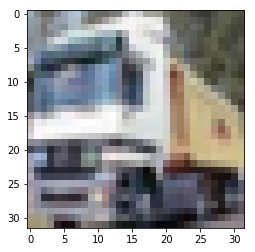

In [0]:
plt.gray()
plt.imshow(x_train[1].reshape([32, 32, 3]))

In [0]:
# 다음 배치를 읽어오기 위한 next_batch 유틸리티 함수를 정의합니다.
def next_batch(num, data, labels):
  '''
  `num` 개수 만큼의 랜덤한 샘플들과 레이블들을 리턴합니다.
  '''
  idx = np.arange(0 , len(data))
  np.random.shuffle(idx)
  idx = idx[:num]
  data_shuffle = [data[ i] for i in idx]
  labels_shuffle = [labels[ i] for i in idx]

  return np.asarray(data_shuffle), np.asarray(labels_shuffle)

# CNN 모델을 정의합니다. 
def build_CNN_classifier(x):
  # 입력 이미지
  x_image = x

  # 첫번째 convolutional layer - 하나의 grayscale 이미지를 64개의 특징들(feature)으로 맵핑(maping)합니다.
  W_conv1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 3, 64], stddev=5e-2))
  b_conv1 = tf.Variable(tf.constant(0.1, shape=[64]))
  h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

  # 첫번째 Pooling layer
  h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

  # 두번째 convolutional layer - 32개의 특징들(feature)을 64개의 특징들(feature)로 맵핑(maping)합니다.
  W_conv2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 64, 64], stddev=5e-2))
  b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))
  h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

  # 두번째 pooling layer.
  h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

  # 세번째 convolutional layer
  W_conv3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], stddev=5e-2))
  b_conv3 = tf.Variable(tf.constant(0.1, shape=[128]))
  h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3)

  # 네번째 convolutional layer
  W_conv4 = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 128], stddev=5e-2))
  b_conv4 = tf.Variable(tf.constant(0.1, shape=[128])) 
  h_conv4 = tf.nn.relu(tf.nn.conv2d(h_conv3, W_conv4, strides=[1, 1, 1, 1], padding='SAME') + b_conv4)

  # 다섯번째 convolutional layer
  W_conv5 = tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 128], stddev=5e-2))
  b_conv5 = tf.Variable(tf.constant(0.1, shape=[128]))
  h_conv5 = tf.nn.relu(tf.nn.conv2d(h_conv4, W_conv5, strides=[1, 1, 1, 1], padding='SAME') + b_conv5)

  # Fully Connected Layer 1 - 2번의 downsampling 이후에, 우리의 32x32 이미지는 8x8x128 특징맵(feature map)이 됩니다.
  # 이를 384개의 특징들로 맵핑(maping)합니다.
  W_fc1 = tf.Variable(tf.truncated_normal(shape=[8 * 8 * 128, 384], stddev=5e-2))
  b_fc1 = tf.Variable(tf.constant(0.1, shape=[384]))

  h_conv5_flat = tf.reshape(h_conv5, [-1, 8*8*128])
  h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

  # Dropout - 모델의 복잡도를 컨트롤합니다. 특징들의 co-adaptation을 방지합니다.
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob) 

  # Fully Connected Layer 2 - 384개의 특징들(feature)을 10개의 클래스-airplane, automobile, bird...-로 맵핑(maping)합니다.
  W_fc2 = tf.Variable(tf.truncated_normal(shape=[384, 10], stddev=5e-2))
  b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
  logits = tf.matmul(h_fc1_drop,W_fc2) + b_fc2
  y_pred = tf.nn.softmax(logits)

  return y_pred, logits

# 인풋 아웃풋 데이터, 드롭아웃 확률을 입력받기위한 플레이스홀더를 정의합니다.
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

# CIFAR-10 데이터를 다운로드하고 데이터를 불러옵니다.
#(x_train, y_train), (x_test, y_test) = load_data()
# scalar 형태의 레이블(0~9)을 One-hot Encoding 형태로 변환합니다.
y_train_one_hot = tf.squeeze(tf.one_hot(y_train, 10),axis=1)
y_test_one_hot = tf.squeeze(tf.one_hot(y_test, 10),axis=1)

# Convolutional Neural Networks(CNN) 그래프를 생성합니다.
y_pred, logits = build_CNN_classifier(x)

# Cross Entropy를 비용함수(loss function)으로 정의하고, RMSPropOptimizer를 이용해서 비용 함수를 최소화합니다.
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
train_step = tf.train.RMSPropOptimizer(1e-3).minimize(loss)

# 정확도를 계산하는 연산을 추가합니다.
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 세션을 열어 실제 학습을 진행합니다.
with tf.Session() as sess:
  # 모든 변수들을 초기화한다. 
  sess.run(tf.global_variables_initializer())
  
  # 10000 Step만큼 최적화를 수행합니다.
  for i in range(10000):
    batch = next_batch(128, x_train, y_train_one_hot.eval())

    # 100 Step마다 training 데이터셋에 대한 정확도와 loss를 출력합니다.
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0})
      loss_print = loss.eval(feed_dict={x: batch[0], y: batch[1], keep_prob: 1.0})

      print("반복(Epoch): %d, 트레이닝 데이터 정확도: %f, 손실 함수(loss): %f" % (i, train_accuracy, loss_print))
    # 20% 확률의 Dropout을 이용해서 학습을 진행합니다.
    sess.run(train_step, feed_dict={x: batch[0], y: batch[1], keep_prob: 0.8})

  # 학습이 끝나면 테스트 데이터(10000개)에 대한 정확도를 출력합니다.  
  test_accuracy = 0.0  
  for i in range(10):
    test_batch = next_batch(1000, x_test, y_test_one_hot.eval())
    test_accuracy = test_accuracy + accuracy.eval(feed_dict={x: test_batch[0], y: test_batch[1], keep_prob: 1.0})
  test_accuracy = test_accuracy / 10;
  print("테스트 데이터 정확도: %f" % test_accuracy)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

반복(Epoch): 0, 트레이닝 데이터 정확도: 0.046875, 손실 함수(loss): 149.198273
반복(Epoch): 100, 트레이닝 데이터 정확도: 0.148438, 손실 함수(loss): 2.264470


KeyboardInterrupt: ignored

## References
* https://www.cs.toronto.edu/~kriz/cifar.html
* http://solarisailab.com/archives/2325